In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
def load_data(user_asset):
    data_path = os.path.join(os.getcwd(), 'dataset_out', user_asset)

    data_frames = {}
    for file in os.listdir(data_path):
        if(file.endswith('.csv')):
            file_path = os.path.join(data_path, file)
            stock = file.split('.')[0]
            data_frames[stock] = pd.read_csv(file_path)

    risk_data = data_frames['risk_data']
    risk_data.columns.values[0] = 'Ticker'
    del data_frames['risk_data']

    ### Convert Date column to datetime
    for stock, df in data_frames.items():
        df['Date'] = pd.to_datetime(df['Date'])
    
    return data_frames, risk_data

In [3]:
def preprocess_data(data_frames):
    scaler = MinMaxScaler()

    normalized_data_frames = {}
    for stock, df in data_frames.items():
        df_norm = df.copy()
        df_norm[df_norm.columns.values[1:]] = scaler.fit_transform(df_norm[df_norm.columns.values[1:]])
        normalized_data_frames[stock] = df_norm
    
    return normalized_data_frames

In [4]:
def generate_train_test_val_data(normalized_data_frames):
    ### Split data into train, test and val sets
    train_test_val_data = {}
    for stock, df in normalized_data_frames.items():
        train_df, test_df = train_test_split(df, test_size = 0.3, shuffle = False)
        test_df, val_df = train_test_split(test_df, test_size = 0.5, shuffle = False)

        scaler = MinMaxScaler()
        train_df[train_df.columns.values[1:]] = scaler.fit_transform(train_df[train_df.columns.values[1:]])
        test_df[test_df.columns.values[1:]] = scaler.transform(test_df[test_df.columns.values[1:]])
        val_df[val_df.columns.values[1:]] = scaler.transform(val_df[val_df.columns.values[1:]])

        train_test_val_data[stock] = (train_df, test_df, val_df)
    return train_test_val_data

In [5]:
def compute_moving_average(df, window = 5):
    MA = df['Close'].rolling(window = window).mean()
    return MA

In [6]:
# Exponential Moving Average: https://www.investopedia.com/terms/e/ema.asp
def compute_EMA(df, window = 5):
    EMA = df['Close'].ewm(span = window, adjust = False).mean()
    return EMA

In [7]:
# Moving Average Convergence Divergence: https://www.investopedia.com/terms/m/macd.asp
def compute_MACD(data, long_term = 26, short_term = 12):
    EMA_12 = compute_EMA(data, short_term)
    EMA_26 = compute_EMA(data, long_term)
    MACD = EMA_12 - EMA_26
    return MACD

In [8]:
# Relative Strength Index: https://www.investopedia.com/terms/r/rsi.asp
def compute_RSI(df, window=14):
    # Get price differences
    delta = df['Close'].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()

    RSI = 100 - (100 / (1 + (avg_gain / avg_loss)))
    return RSI

In [9]:
# Bollinger Bands: https://www.investopedia.com/terms/b/bollingerbands.asp
def compute_bollinger_bands(df, window = 20):
    ma = compute_moving_average(df, window)
    std = df['Close'].rolling(window = window).std()
    BOLU = ma + 2 * std # upper band
    BOLD = ma - 2 * std # lower band
    return BOLU, BOLD

In [10]:
def generate_timeseries_windows(data, window_size = 10, forecast_range = 1, shift = 1):
    windows = []
    labels = []
    for xx in range(0, len(data) - window_size - forecast_range, shift):
        window = data[xx : xx + window_size + forecast_range]
        #if(len(window) == window_size + forecast_range):
        windows.append(window[:-forecast_range])
        labels.append(window[-1][4])
    return np.array(windows), np.array(labels)

In [11]:
def feature_engineering(data_frames):
    feature_engineered_df = {}

    for stock, df in data_frames.items():
        df_eng = df.copy()
        df_eng[f'MA_{5}'] = compute_moving_average(df, 5)
        #df_eng[f'MA_{10}'] = compute_moving_average(df, 10)
        #df_eng[f'MA_{20}'] = compute_moving_average(df, 20)

        df_eng[f'EMA_{5}'] = compute_EMA(df, 5)
        #df_eng[f'EMA_{10}'] = compute_EMA(df, 10)
        #df_eng[f'EMA_{20}'] = compute_EMA(df, 20)
        
        df_eng['RSI'] = compute_RSI(df)
        df_eng['MACD'] = compute_MACD(df)
        df_eng['BOLU'], df_eng['BOLD'] = compute_bollinger_bands(df)

        df_eng = df_eng.dropna()
        feature_engineered_df[stock] = df_eng

    return feature_engineered_df

In [12]:
def convert_to_tensor(train_data, train_labels, test_data, test_labels, val_data, val_labels):
    train_data_tensor = np.asarray(train_data, dtype=np.float32)
    train_data_tensor = torch.from_numpy(train_data_tensor)
    train_labels_tensor = torch.tensor(train_labels, dtype = torch.float32)

    test_data_tensor = np.asarray(test_data, dtype=np.float32)
    test_data_tensor = torch.from_numpy(test_data_tensor)
    test_labels_tensor = torch.tensor(test_labels, dtype = torch.float32)

    val_data_tensor = np.asarray(val_data, dtype=np.float32)
    val_data_tensor = torch.from_numpy(val_data_tensor)
    val_labels_tensor = torch.tensor(val_labels, dtype = torch.float32)

    return train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor, val_data_tensor, val_labels_tensor

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_layer_size=8, hidden_layer_size=256, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_layer_size, hidden_layer_size, num_layers, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x[:, -1, :])
        return x

In [14]:
### Train model
def train_model(model, train_data_tensor, train_labels_tensor, n_epochs = 100, learning_rate = 0.001):
    ### Loss function
    criterion = nn.MSELoss()

    ### Optimizer
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    model.train() # set model to train mode
    for epoch in range(0, n_epochs):
        optimizer.zero_grad()
        output = model(train_data_tensor)
        output = output.squeeze()
        train_loss = criterion(output, train_labels_tensor)
        train_loss.backward()
        optimizer.step()
        
        if ((epoch+1) % 10 == 0):
            print("Epoch: {}/{} \t Train Loss: {:.6f}".format(epoch + 1, n_epochs, train_loss))

In [15]:
def save_model(user_asset, ticker, model):
    #model output path
    model_output_path = f"{os.getcwd()}/models/{user_asset}"
    if not os.path.exists(model_output_path):
        os.makedirs(model_output_path)
    torch.save(model.state_dict(), f"{model_output_path}/model_{ticker}.pt")

In [16]:
def load_model(user_asset, ticker):
    model_output_path = f"{os.getcwd()}/models/{user_asset}"
    model = LSTM()
    model.load_state_dict(torch.load(f"{model_output_path}/model_{ticker}.pt"))
    return model

In [17]:
### Evaluate model
def evaluate_model(model, test_data_tensor, test_labels_tensor):
    ### Loss function
    criterion = nn.MSELoss()

    model.eval() # set model to evaluation mode

    with torch.no_grad():
        output = model(test_data_tensor)
        output = output.squeeze()
        test_loss = criterion(output, test_labels_tensor)
        print("Test Loss: {:.6f}".format(test_loss))

    return output.squeeze().numpy()

In [18]:
def regression_metrics(test_labels_tensor, output_single_stock):
    test_labels = test_labels_tensor.numpy()
    mse = mean_squared_error(test_labels, output_single_stock)
    print(('MSE: {}').format(mse))
    return mse

In [19]:
def classification_metrics(test_labels_tensor, output_single_stock):
    test_labels = test_labels_tensor.numpy()
    ### Calculate classification metrics
    test_labels_trend = (test_labels[20:] > test_labels[:-20])
    output_single_stock_trend = (output_single_stock[20:] > test_labels[:-20])

    ### Compute classification metrics
    accuracy = accuracy_score(test_labels_trend, output_single_stock_trend)
    precision = precision_score(test_labels_trend, output_single_stock_trend)
    recall = recall_score(test_labels_trend, output_single_stock_trend)
    f1 = f1_score(test_labels_trend, output_single_stock_trend)
    print(('Accuracy: {}').format(accuracy))
    print(('Precision: {}').format(precision))
    print(('Recall: {}').format(recall))
    print(('F1: {}').format(f1))

    ConfusionMatrixDisplay.from_predictions(test_labels_trend, output_single_stock_trend)
    plt.show()

In [20]:
def plot_predictions(test_df, output_single_stock):
    plt.figure(figsize=(10, 6))
    plt.plot(test_df['Date'], test_df['Close'], label = 'Actual')
    plt.plot(test_df['Date'][len(test_df) - len(output_single_stock):], output_single_stock, label = 'Predicted')
    plt.xlabel('Days')
    plt.ylabel('Normalized Price')
    plt.title('Stock Price Prediction with LSTM')
    plt.legend()
    plt.show()

In [21]:
### Evaluate model
def eval_model_performance(ticker, output_single_stock, val_df, val_labels):
    """
    Evaluates the model for a specific ticker and output

    Args:
        ticker: stock tricker
        output_single_stock: prediction price values returned by the model; shape = (n, 1)
        val_df: the validation data, must contain 'Date' and 'Close' column
        val_labels: the labels of the validation set; shape = (m, 1)
    
    Returns:
        MSE
    """
    print("Evaluating model for {}...".format(ticker))  
    mse = regression_metrics(val_labels, output_single_stock)
    classification_metrics(val_labels, output_single_stock)

    ### Plot predictions
    plot_predictions(val_df, output_single_stock)

    return mse

In [23]:
def build_train_lstm(train_df, test_df, val_df, user_asset = 'stock', ticker = 'AAPL', forecast_range = 20, window_size = 100, n_epochs = 100, learning_rate = 0.001, hidden_layer_size = 256, eval=False):
    train_data, train_labels = generate_timeseries_windows(train_df.values, window_size, shift = 1)
    test_data, test_labels = generate_timeseries_windows(test_df.values, window_size, shift = 1)
    val_data, val_labels = generate_timeseries_windows(val_df.values, window_size, shift = 1)
    train_data = np.delete(train_data, [0], axis = 2)
    test_data = np.delete(test_data, [0], axis = 2)
    val_data = np.delete(val_data, [0], axis = 2)

    ### Convert data to tensors
    train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor, val_data_tensor, val_labels_tensor = convert_to_tensor(train_data, train_labels, test_data, test_labels, val_data, val_labels)
    print(train_data_tensor.shape)
    ### Build LSTM model
    model = LSTM(hidden_layer_size = hidden_layer_size, input_layer_size = train_data_tensor.shape[2])

    ### Train model
    print("Training model for {}...".format(ticker))
    train_model(model, train_data_tensor, train_labels_tensor, n_epochs, learning_rate)

    ### Evaluate model
    output_single_stock = evaluate_model(model, val_data_tensor, val_labels_tensor)

    ### Save model
    print("Saving model for {}...".format(ticker))
    save_model(user_asset, ticker, model)

    if(eval):
        mse = eval_model_performance(ticker, output_single_stock, val_df, val_labels_tensor)

In [24]:
data_frames, risk_data = load_data('stock')
normalized_data_frames = preprocess_data(data_frames)
#feature_engineered_data_frames = feature_engineering(normalized_data_frames)
train_test_val_data = generate_train_test_val_data(normalized_data_frames)

torch.Size([1671, 90, 8])
Training model for AAPL...
Epoch: 10/100 	 Train Loss: 0.016406
Epoch: 20/100 	 Train Loss: 0.002585
Epoch: 30/100 	 Train Loss: 0.000546
Epoch: 40/100 	 Train Loss: 0.000393
Epoch: 50/100 	 Train Loss: 0.000301
Epoch: 60/100 	 Train Loss: 0.000314
Epoch: 70/100 	 Train Loss: 0.000303
Epoch: 80/100 	 Train Loss: 0.000270
Epoch: 90/100 	 Train Loss: 0.000262
Epoch: 100/100 	 Train Loss: 0.000260
Test Loss: 0.000264
Saving model for AAPL...
Evaluating model for AAPL...
MSE: 0.00026354589499533176
Accuracy: 0.9325842696629213
Precision: 0.9282296650717703
Recall: 0.9847715736040609
F1: 0.9556650246305418


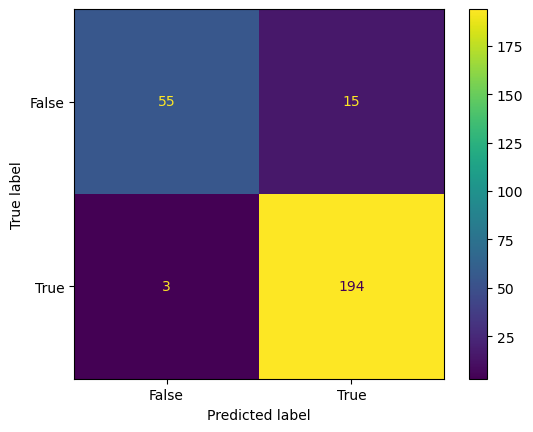

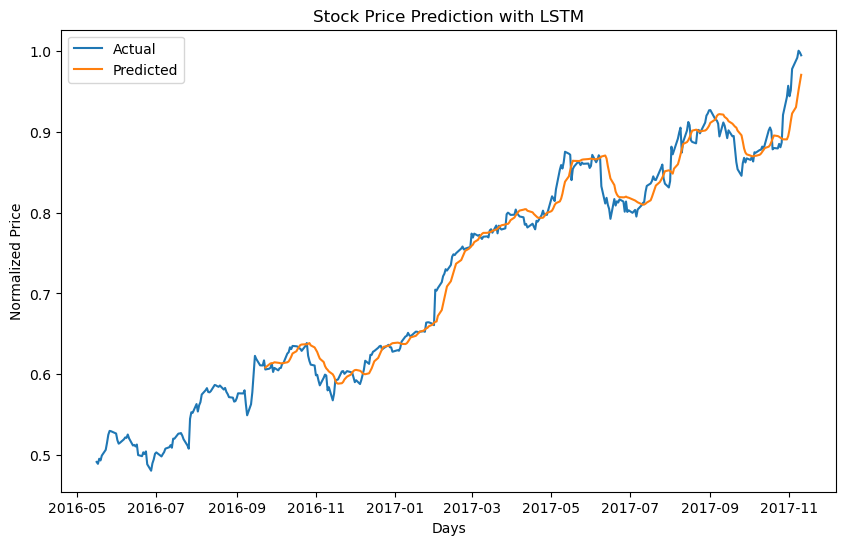

In [25]:
### Simple pipeline test
stock = 'AAPL'
train_df, test_df, val_df = train_test_val_data[stock]
train_df.columns
build_train_lstm(train_df, test_df, val_df, user_asset = 'stock', ticker = stock, forecast_range = 20, window_size = 90, n_epochs = 100, learning_rate = 0.001, hidden_layer_size = 256, eval=True)

In [28]:
### Main Training Pipeline - use .txt file for stock selection

stock_selection_path = os.path.join(os.getcwd(), 'medium_risk_stocks_300-36.txt')

window_size = 90
n_epochs = 100
learning_rate = 0.001
hidden_layer_size = 256

with open(stock_selection_path) as stocks:
    for stock in stocks:
        stock = stock.strip()
        train_df, test_df, val_df = train_test_val_data[stock]
        train_df.columns
        build_train_lstm(train_df, test_df, val_df, user_asset = 'stock', ticker = stock, forecast_range = 21, window_size = window_size, n_epochs = n_epochs, learning_rate = learning_rate, hidden_layer_size = hidden_layer_size, eval=False)

torch.Size([1670, 90, 8])
Training model for CNO...
Epoch: 10/100 	 Train Loss: 0.023126
Epoch: 20/100 	 Train Loss: 0.004406
Epoch: 30/100 	 Train Loss: 0.000818
Epoch: 40/100 	 Train Loss: 0.000769
Epoch: 50/100 	 Train Loss: 0.000607
Epoch: 60/100 	 Train Loss: 0.000560
Epoch: 70/100 	 Train Loss: 0.000498
Epoch: 80/100 	 Train Loss: 0.000498
Epoch: 90/100 	 Train Loss: 0.000488
Epoch: 100/100 	 Train Loss: 0.000440
Test Loss: 0.000328
Saving model for CNO...
torch.Size([1670, 90, 8])
Training model for FMO...
Epoch: 10/100 	 Train Loss: 0.037102
Epoch: 20/100 	 Train Loss: 0.015526
Epoch: 30/100 	 Train Loss: 0.004221
Epoch: 40/100 	 Train Loss: 0.001228
Epoch: 50/100 	 Train Loss: 0.001263
Epoch: 60/100 	 Train Loss: 0.001073
Epoch: 70/100 	 Train Loss: 0.000978
Epoch: 80/100 	 Train Loss: 0.000961
Epoch: 90/100 	 Train Loss: 0.000980
Epoch: 100/100 	 Train Loss: 0.000913
Test Loss: 0.000516
Saving model for FMO...
torch.Size([1670, 90, 8])
Training model for KMX...
Epoch: 10/100 

### Random Experiments

Training model for AAPL...
Epoch: 10/100 	 Train Loss: 0.028731
Epoch: 20/100 	 Train Loss: 0.011456
Epoch: 30/100 	 Train Loss: 0.002748
Epoch: 40/100 	 Train Loss: 0.001098
Epoch: 50/100 	 Train Loss: 0.001084
Epoch: 60/100 	 Train Loss: 0.000865
Epoch: 70/100 	 Train Loss: 0.000654
Epoch: 80/100 	 Train Loss: 0.000704
Epoch: 90/100 	 Train Loss: 0.000635
Epoch: 100/100 	 Train Loss: 0.000576
Evaluating model for AAPL...
Test Loss: 0.001155
MSE: 0.0011553874937817454
Accuracy: 0.7667844522968198
Precision: 0.9741935483870968
Recall: 0.7089201877934272
F1: 0.8206521739130435
Saving model for AAPL...


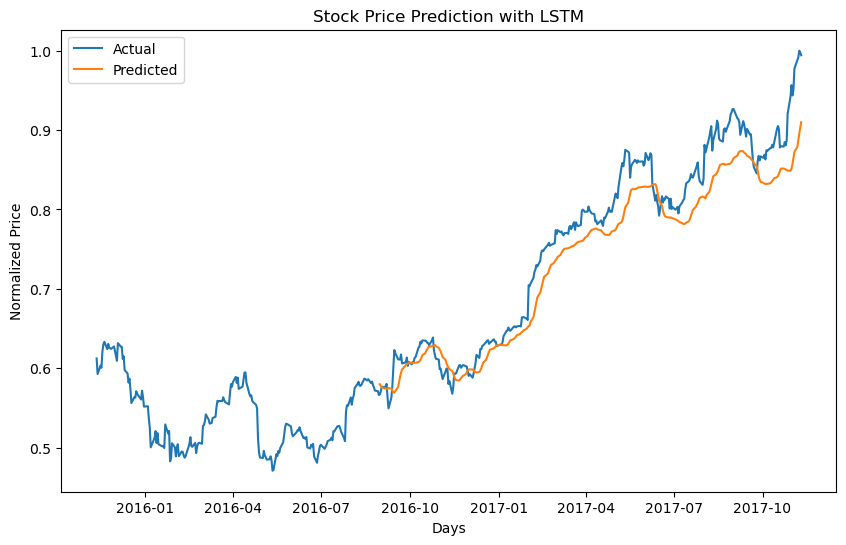

In [82]:
### Window Size Experiment
window_lengths = range(10, 200, 10)
stock = 'AAPL'
train_df, test_df = train_test_data[stock]
mse_outputs = dict()

# build_train_lstm does not return mse anymore (adjust if you want to run experiment again)
for window_size in window_lengths:
    mse = build_train_lstm(train_df, test_df, user_asset = 'stock', ticker = stock, forecast_range = 20, window_size = window_size, n_epochs = 100, learning_rate = 0.001, hidden_layer_size = 128)
    mse_outputs[window_size] = mse

In [111]:
### Window Size Experiment for several stocks
tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NFLX', 'WMT', 'IBM', 'SNPS', 'ADBE', 'NVDA', 'CRM', 'AMD', 'INTC', 'ACN', 'ORCL', 'CSCO', 'ANSS']
window_lengths = range(50, 150, 5)
mse_outputs = dict()
size_outputs = dict()

# build_train_lstm does not return mse anymore (adjust if you want to run experiment again)

for stock in tickers:
    train_df, test_df = train_test_data[stock]
    best_mse = 1
    best_window_size = 0
    for window_size in window_lengths:
        mse = build_train_eval_lstm(train_df, test_df, user_asset = 'stock', ticker = stock, forecast_range = 20, window_size = window_size, n_epochs = 100, learning_rate = 0.001, hidden_layer_size = 128)
        if(mse < best_mse):
            mse_outputs[stock] = mse
            size_outputs[stock] = window_size
            best_mse = mse

"tickers = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NFLX', 'WMT', 'IBM', 'SNPS', 'ADBE', 'NVDA', 'CRM', 'AMD', 'INTC', 'ACN', 'ORCL', 'CSCO', 'ANSS']\nwindow_lengths = range(50, 150, 5)\nmse_outputs = dict()\nsize_outputs = dict()\n\nfor stock in tickers:\n    train_df, test_df = train_test_data[stock]\n    best_mse = 1\n    best_window_size = 0\n    for window_size in window_lengths:\n        mse = build_train_eval_lstm(train_df, test_df, user_asset = 'stock', ticker = stock, forecast_range = 20, window_size = window_size, n_epochs = 100, learning_rate = 0.001, hidden_layer_size = 128)\n        if(mse < best_mse):\n            mse_outputs[stock] = mse\n            size_outputs[stock] = window_size\n            best_mse = mse"

Training model for AAPL...
Epoch: 10/100 	 Train Loss: 0.021102
Epoch: 20/100 	 Train Loss: 0.004949
Epoch: 30/100 	 Train Loss: 0.001547
Epoch: 40/100 	 Train Loss: 0.000775
Epoch: 50/100 	 Train Loss: 0.000371
Epoch: 60/100 	 Train Loss: 0.000321
Epoch: 70/100 	 Train Loss: 0.000316
Epoch: 80/100 	 Train Loss: 0.000304
Epoch: 90/100 	 Train Loss: 0.000311
Epoch: 100/100 	 Train Loss: 0.000291
Evaluating model for AAPL...
Test Loss: 0.000341
MSE: 0.00034104997757822275
Accuracy: 0.9211195928753181
Precision: 0.9626865671641791
Recall: 0.9247311827956989
F1: 0.943327239488117
Saving model for AAPL...


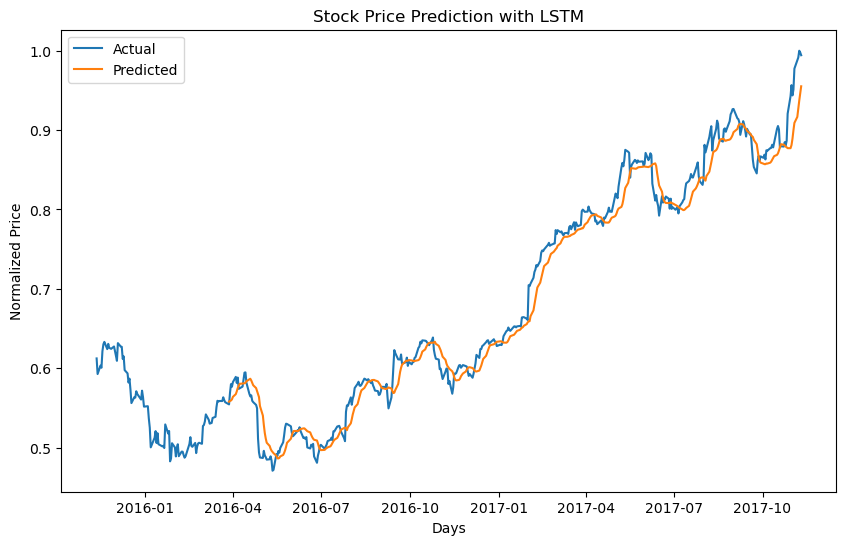

Training model for AMZN...
Epoch: 10/100 	 Train Loss: 0.010677
Epoch: 20/100 	 Train Loss: 0.001140
Epoch: 30/100 	 Train Loss: 0.000733
Epoch: 40/100 	 Train Loss: 0.000297
Epoch: 50/100 	 Train Loss: 0.000200
Epoch: 60/100 	 Train Loss: 0.000199
Epoch: 70/100 	 Train Loss: 0.000202
Epoch: 80/100 	 Train Loss: 0.000201
Epoch: 90/100 	 Train Loss: 0.000172
Epoch: 100/100 	 Train Loss: 0.000173
Evaluating model for AMZN...
Test Loss: 0.001505
MSE: 0.0015048657078295946
Accuracy: 0.8269720101781171
Precision: 0.816711590296496
Recall: 1.0
F1: 0.8991097922848665
Saving model for AMZN...


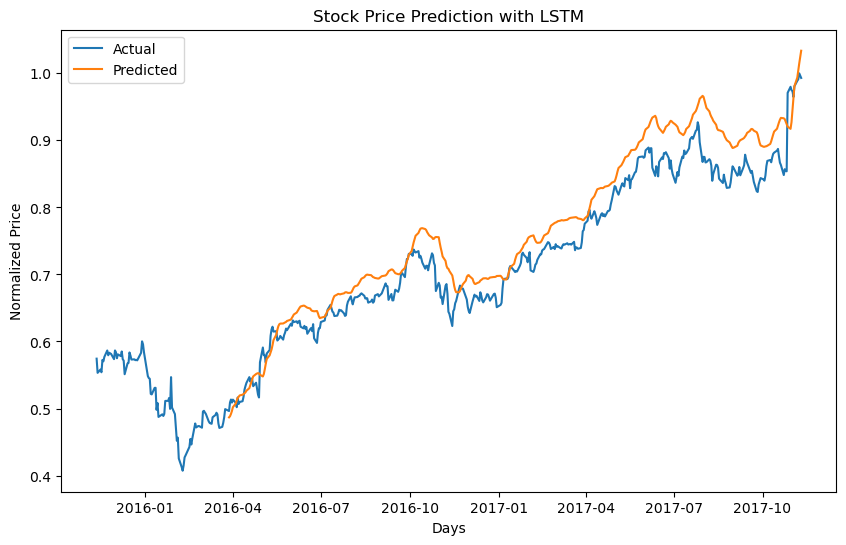

Training model for GOOGL...
Epoch: 10/100 	 Train Loss: 0.017809
Epoch: 20/100 	 Train Loss: 0.002416
Epoch: 30/100 	 Train Loss: 0.001779
Epoch: 40/100 	 Train Loss: 0.000833
Epoch: 50/100 	 Train Loss: 0.000575
Epoch: 60/100 	 Train Loss: 0.000447
Epoch: 70/100 	 Train Loss: 0.000345
Epoch: 80/100 	 Train Loss: 0.000322
Epoch: 90/100 	 Train Loss: 0.000340
Epoch: 100/100 	 Train Loss: 0.000304
Evaluating model for GOOGL...
Test Loss: 0.000739
MSE: 0.0007389408419840038
Accuracy: 0.8193384223918575
Precision: 0.7870370370370371
Recall: 0.9922178988326849
F1: 0.8777969018932875
Saving model for GOOGL...


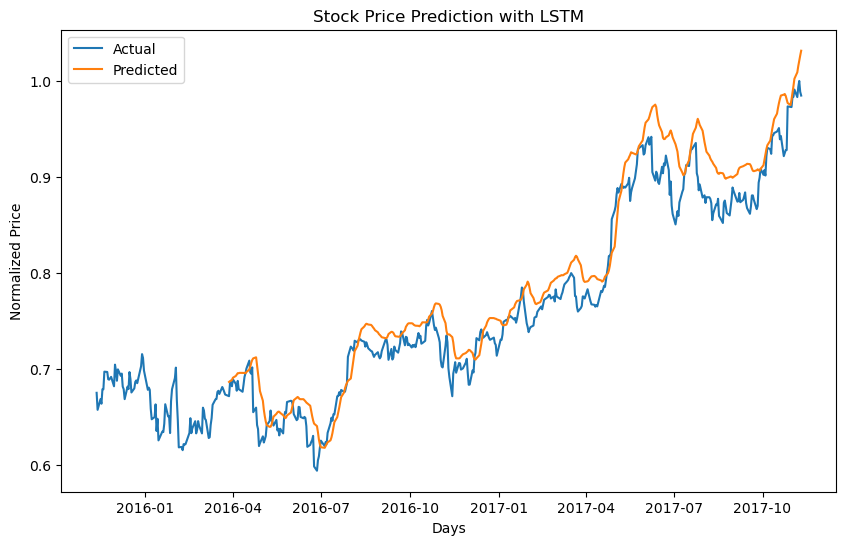

Training model for MSFT...
Epoch: 10/100 	 Train Loss: 0.012185
Epoch: 20/100 	 Train Loss: 0.001592
Epoch: 30/100 	 Train Loss: 0.000616
Epoch: 40/100 	 Train Loss: 0.000363
Epoch: 50/100 	 Train Loss: 0.000340
Epoch: 60/100 	 Train Loss: 0.000297
Epoch: 70/100 	 Train Loss: 0.000270
Epoch: 80/100 	 Train Loss: 0.000225
Epoch: 90/100 	 Train Loss: 0.000223
Epoch: 100/100 	 Train Loss: 0.000226
Evaluating model for MSFT...
Test Loss: 0.000324
MSE: 0.0003235041513107717
Accuracy: 0.8600508905852418
Precision: 0.8518518518518519
Recall: 0.9900662251655629
F1: 0.9157733537519142
Saving model for MSFT...


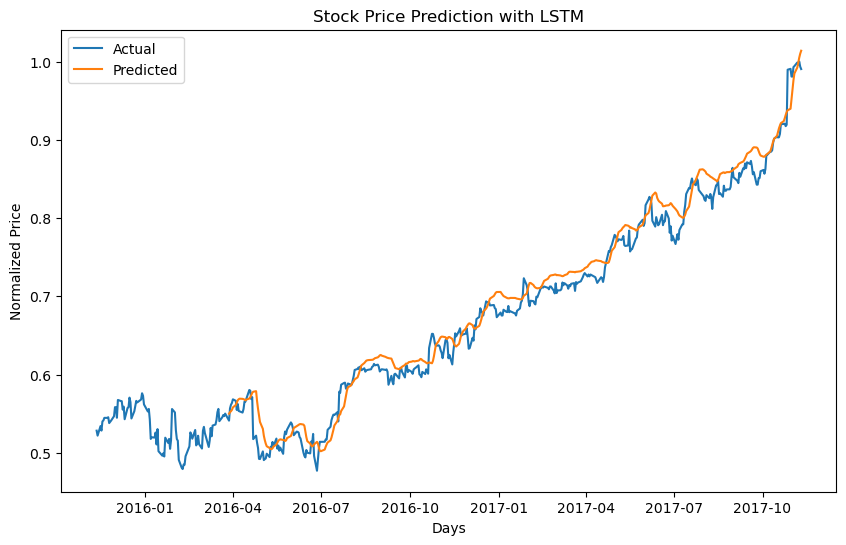

Training model for NFLX...
Epoch: 10/100 	 Train Loss: 0.012928
Epoch: 20/100 	 Train Loss: 0.002629
Epoch: 30/100 	 Train Loss: 0.000786
Epoch: 40/100 	 Train Loss: 0.000755
Epoch: 50/100 	 Train Loss: 0.000285
Epoch: 60/100 	 Train Loss: 0.000303
Epoch: 70/100 	 Train Loss: 0.000260
Epoch: 80/100 	 Train Loss: 0.000251
Epoch: 90/100 	 Train Loss: 0.000236
Epoch: 100/100 	 Train Loss: 0.000250
Evaluating model for NFLX...
Test Loss: 0.000851
MSE: 0.0008513150387443602
Accuracy: 0.8422391857506362
Precision: 0.9333333333333333
Recall: 0.8296296296296296
F1: 0.8784313725490196
Saving model for NFLX...


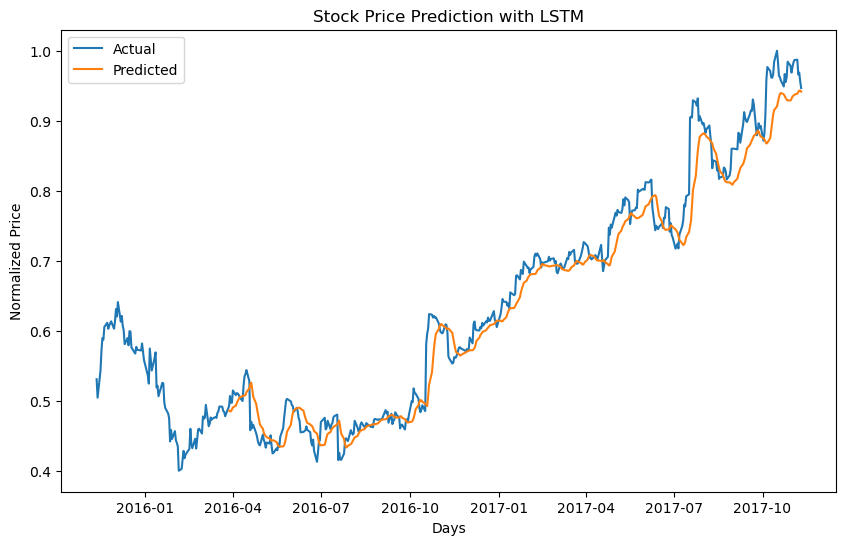

Training model for WMT...
Epoch: 10/100 	 Train Loss: 0.029108
Epoch: 20/100 	 Train Loss: 0.007435
Epoch: 30/100 	 Train Loss: 0.003227
Epoch: 40/100 	 Train Loss: 0.001548
Epoch: 50/100 	 Train Loss: 0.000897
Epoch: 60/100 	 Train Loss: 0.000728
Epoch: 70/100 	 Train Loss: 0.000748
Epoch: 80/100 	 Train Loss: 0.000668
Epoch: 90/100 	 Train Loss: 0.000720
Epoch: 100/100 	 Train Loss: 0.000697
Evaluating model for WMT...
Test Loss: 0.000576
MSE: 0.0005757303442806005
Accuracy: 0.8625954198473282
Precision: 0.9254385964912281
Recall: 0.8508064516129032
F1: 0.8865546218487396
Saving model for WMT...


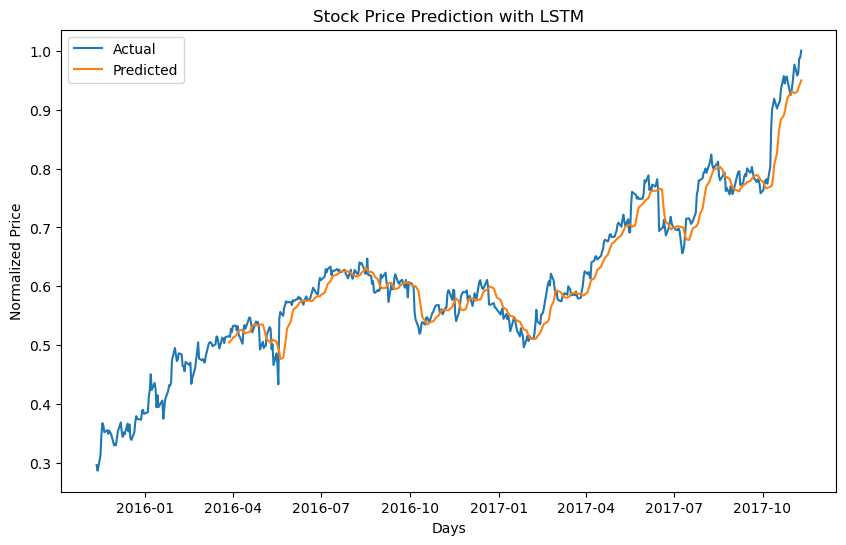

Training model for IBM...
Epoch: 10/100 	 Train Loss: 0.064283
Epoch: 20/100 	 Train Loss: 0.019845
Epoch: 30/100 	 Train Loss: 0.016915
Epoch: 40/100 	 Train Loss: 0.002835
Epoch: 50/100 	 Train Loss: 0.003469
Epoch: 60/100 	 Train Loss: 0.001443
Epoch: 70/100 	 Train Loss: 0.001451
Epoch: 80/100 	 Train Loss: 0.001384
Epoch: 90/100 	 Train Loss: 0.001363
Epoch: 100/100 	 Train Loss: 0.001367
Evaluating model for IBM...
Test Loss: 0.000440
MSE: 0.0004400112375151366
Accuracy: 0.9033078880407125
Precision: 0.8793103448275862
Recall: 0.9532710280373832
F1: 0.9147982062780269
Saving model for IBM...


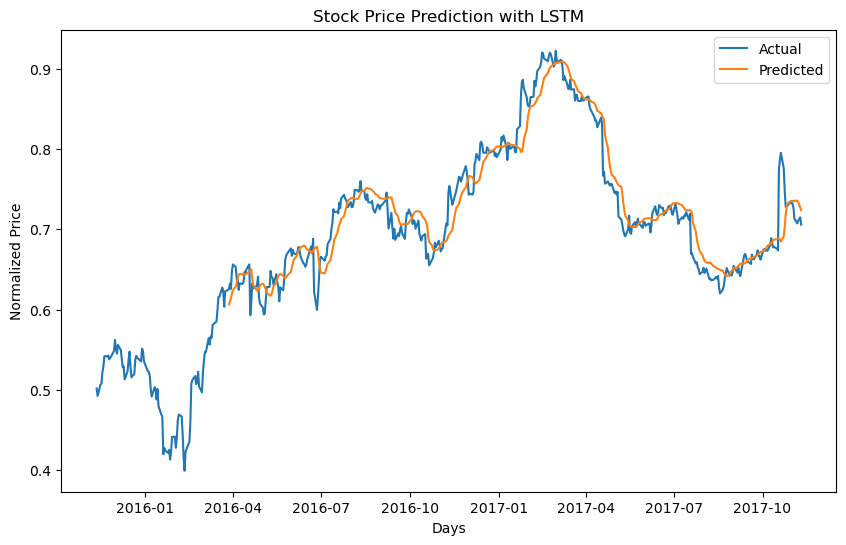

Training model for SNPS...
Epoch: 10/100 	 Train Loss: 0.013224
Epoch: 20/100 	 Train Loss: 0.001673
Epoch: 30/100 	 Train Loss: 0.002322
Epoch: 40/100 	 Train Loss: 0.000355
Epoch: 50/100 	 Train Loss: 0.000263
Epoch: 60/100 	 Train Loss: 0.000235
Epoch: 70/100 	 Train Loss: 0.000205
Epoch: 80/100 	 Train Loss: 0.000202
Epoch: 90/100 	 Train Loss: 0.000199
Epoch: 100/100 	 Train Loss: 0.000180
Evaluating model for SNPS...
Test Loss: 0.000207
MSE: 0.00020736553415190428
Accuracy: 0.8651399491094147
Precision: 0.8782608695652174
Recall: 0.964968152866242
F1: 0.9195751138088013
Saving model for SNPS...


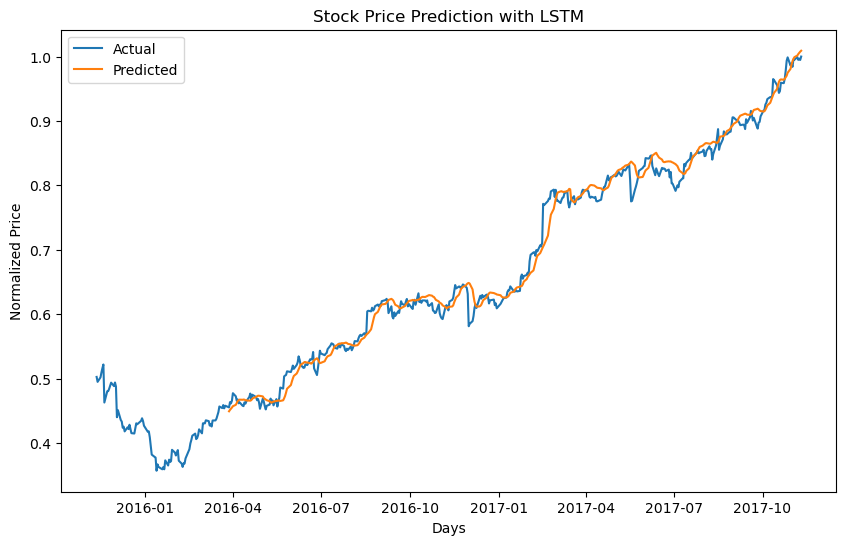

Training model for ADBE...
Epoch: 10/100 	 Train Loss: 0.011276
Epoch: 20/100 	 Train Loss: 0.003137
Epoch: 30/100 	 Train Loss: 0.000480
Epoch: 40/100 	 Train Loss: 0.000318
Epoch: 50/100 	 Train Loss: 0.000238
Epoch: 60/100 	 Train Loss: 0.000238
Epoch: 70/100 	 Train Loss: 0.000200
Epoch: 80/100 	 Train Loss: 0.000200
Epoch: 90/100 	 Train Loss: 0.000179
Epoch: 100/100 	 Train Loss: 0.000187
Evaluating model for ADBE...
Test Loss: 0.000689
MSE: 0.000688946689479053
Accuracy: 0.8295165394402035
Precision: 0.8204419889502762
Recall: 0.9933110367892977
F1: 0.8986384266263239
Saving model for ADBE...


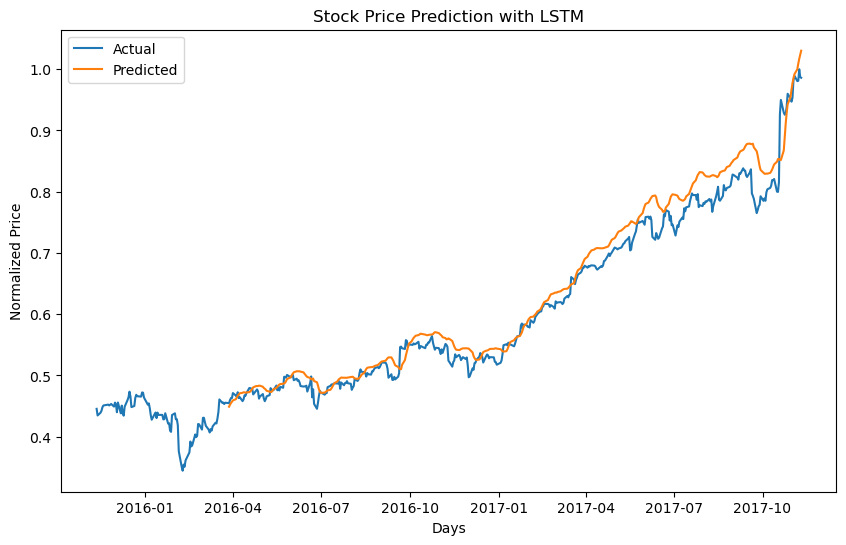

Training model for NVDA...
Epoch: 10/100 	 Train Loss: 0.000602
Epoch: 20/100 	 Train Loss: 0.000475
Epoch: 30/100 	 Train Loss: 0.000391
Epoch: 40/100 	 Train Loss: 0.000349
Epoch: 50/100 	 Train Loss: 0.000206
Epoch: 60/100 	 Train Loss: 0.000087
Epoch: 70/100 	 Train Loss: 0.000053
Epoch: 80/100 	 Train Loss: 0.000040
Epoch: 90/100 	 Train Loss: 0.000031
Epoch: 100/100 	 Train Loss: 0.000029
Evaluating model for NVDA...
Test Loss: 0.002812
MSE: 0.002812097780406475
Accuracy: 0.7557251908396947
Precision: 0.9124087591240876
Recall: 0.7763975155279503
F1: 0.8389261744966442
Saving model for NVDA...


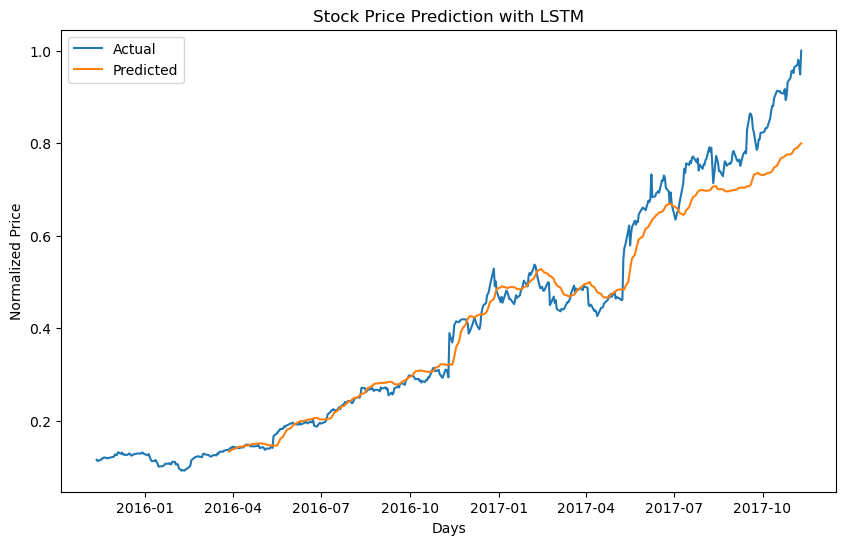

Training model for CRM...
Epoch: 10/100 	 Train Loss: 0.025216
Epoch: 20/100 	 Train Loss: 0.006100
Epoch: 30/100 	 Train Loss: 0.001953
Epoch: 40/100 	 Train Loss: 0.001108
Epoch: 50/100 	 Train Loss: 0.000667
Epoch: 60/100 	 Train Loss: 0.000539
Epoch: 70/100 	 Train Loss: 0.000495
Epoch: 80/100 	 Train Loss: 0.000490
Epoch: 90/100 	 Train Loss: 0.000487
Epoch: 100/100 	 Train Loss: 0.000441
Evaluating model for CRM...
Test Loss: 0.000379
MSE: 0.00037911999970674515
Accuracy: 0.8346055979643766
Precision: 0.9342723004694836
Recall: 0.796
F1: 0.8596112311015119
Saving model for CRM...


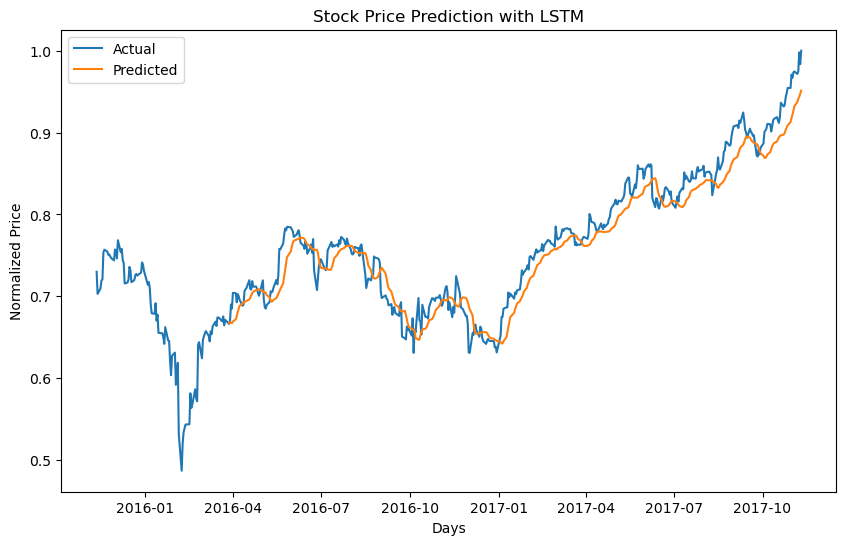

Training model for AMD...
Epoch: 10/100 	 Train Loss: 0.019602
Epoch: 20/100 	 Train Loss: 0.003855
Epoch: 30/100 	 Train Loss: 0.001947
Epoch: 40/100 	 Train Loss: 0.001363
Epoch: 50/100 	 Train Loss: 0.000919
Epoch: 60/100 	 Train Loss: 0.000773
Epoch: 70/100 	 Train Loss: 0.000734
Epoch: 80/100 	 Train Loss: 0.000661
Epoch: 90/100 	 Train Loss: 0.000629
Epoch: 100/100 	 Train Loss: 0.000614
Evaluating model for AMD...
Test Loss: 0.002266
MSE: 0.002265815855935216
Accuracy: 0.9033078880407125
Precision: 0.9310344827586207
Recall: 0.9239543726235742
F1: 0.9274809160305343
Saving model for AMD...


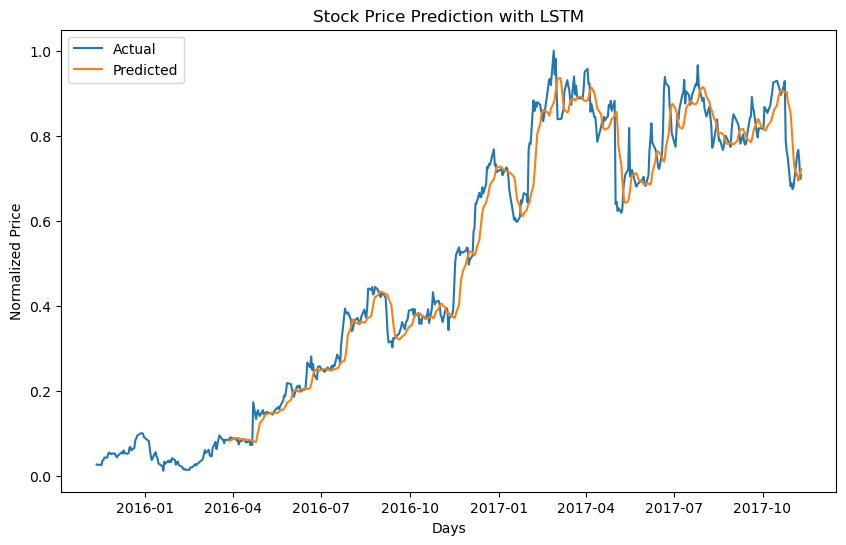

Training model for INTC...
Epoch: 10/100 	 Train Loss: 0.017674
Epoch: 20/100 	 Train Loss: 0.003726
Epoch: 30/100 	 Train Loss: 0.000872
Epoch: 40/100 	 Train Loss: 0.000622
Epoch: 50/100 	 Train Loss: 0.000501
Epoch: 60/100 	 Train Loss: 0.000454
Epoch: 70/100 	 Train Loss: 0.000439
Epoch: 80/100 	 Train Loss: 0.000418
Epoch: 90/100 	 Train Loss: 0.000392
Epoch: 100/100 	 Train Loss: 0.000412
Evaluating model for INTC...
Test Loss: 0.000417
MSE: 0.0004171178734395653
Accuracy: 0.9134860050890585
Precision: 0.9539748953974896
Recall: 0.9083665338645418
F1: 0.9306122448979591
Saving model for INTC...


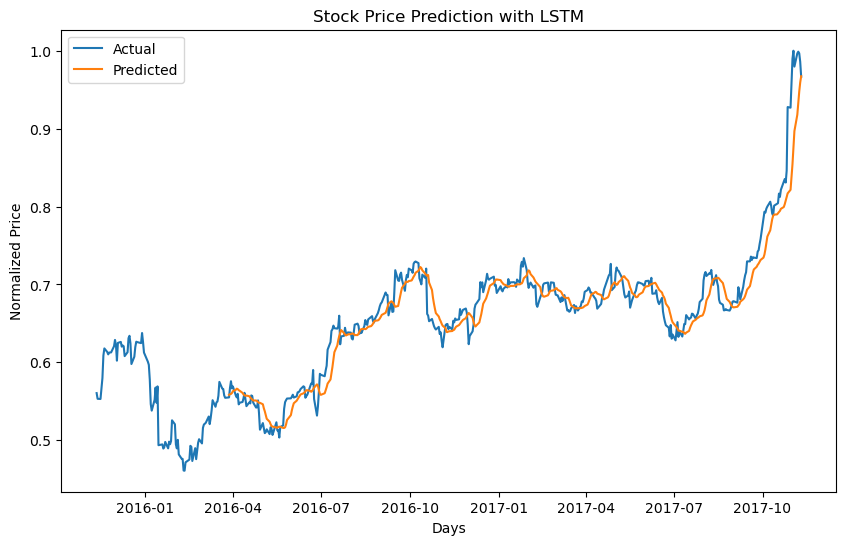

Training model for ACN...
Epoch: 10/100 	 Train Loss: 0.019529
Epoch: 20/100 	 Train Loss: 0.002260
Epoch: 30/100 	 Train Loss: 0.001766
Epoch: 40/100 	 Train Loss: 0.000818
Epoch: 50/100 	 Train Loss: 0.000424
Epoch: 60/100 	 Train Loss: 0.000372
Epoch: 70/100 	 Train Loss: 0.000321
Epoch: 80/100 	 Train Loss: 0.000342
Epoch: 90/100 	 Train Loss: 0.000319
Epoch: 100/100 	 Train Loss: 0.000329
Evaluating model for ACN...
Test Loss: 0.000378
MSE: 0.00037800759309902787
Accuracy: 0.806615776081425
Precision: 0.9311926605504587
Recall: 0.7689393939393939
F1: 0.842323651452282
Saving model for ACN...


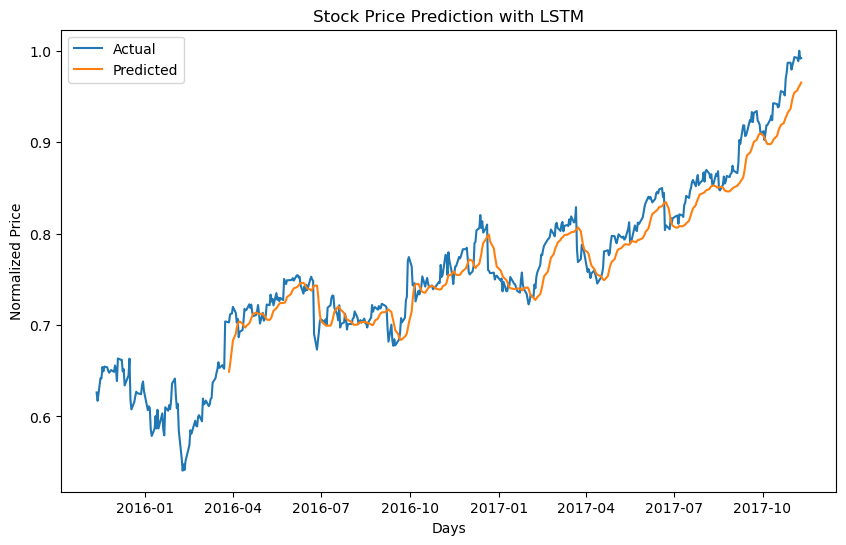

Training model for ORCL...
Epoch: 10/100 	 Train Loss: 0.028210
Epoch: 20/100 	 Train Loss: 0.006865
Epoch: 30/100 	 Train Loss: 0.003301
Epoch: 40/100 	 Train Loss: 0.001715
Epoch: 50/100 	 Train Loss: 0.001115
Epoch: 60/100 	 Train Loss: 0.000985
Epoch: 70/100 	 Train Loss: 0.000808
Epoch: 80/100 	 Train Loss: 0.000813
Epoch: 90/100 	 Train Loss: 0.000768
Epoch: 100/100 	 Train Loss: 0.000752
Evaluating model for ORCL...
Test Loss: 0.000449
MSE: 0.0004492687003221363
Accuracy: 0.8676844783715013
Precision: 0.9
Recall: 0.8771186440677966
F1: 0.8884120171673819
Saving model for ORCL...


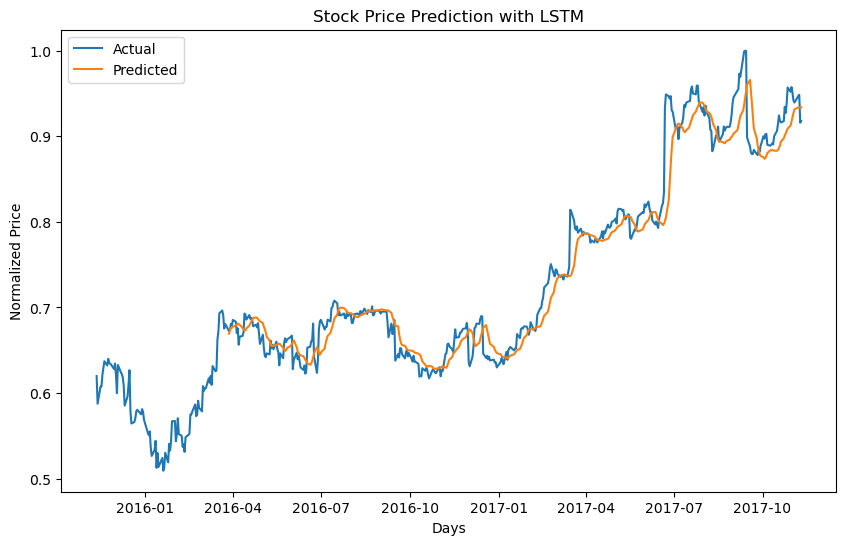

Training model for CSCO...
Epoch: 10/100 	 Train Loss: 0.022502
Epoch: 20/100 	 Train Loss: 0.010370
Epoch: 30/100 	 Train Loss: 0.002658
Epoch: 40/100 	 Train Loss: 0.001577
Epoch: 50/100 	 Train Loss: 0.000994
Epoch: 60/100 	 Train Loss: 0.000861
Epoch: 70/100 	 Train Loss: 0.000728
Epoch: 80/100 	 Train Loss: 0.000711
Epoch: 90/100 	 Train Loss: 0.000682
Epoch: 100/100 	 Train Loss: 0.000688
Evaluating model for CSCO...
Test Loss: 0.000423
MSE: 0.0004228820325806737
Accuracy: 0.8447837150127226
Precision: 0.8851063829787233
Recall: 0.859504132231405
F1: 0.8721174004192872
Saving model for CSCO...


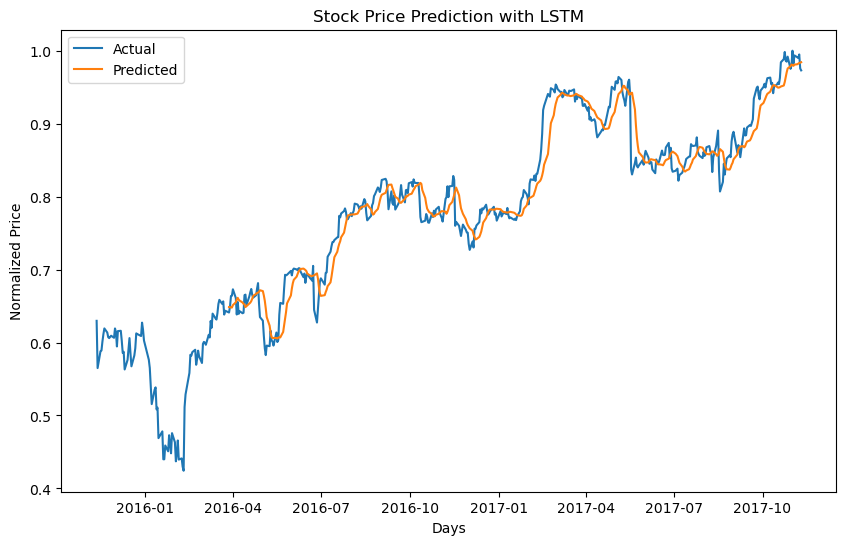

Training model for ANSS...
Epoch: 10/100 	 Train Loss: 0.020522
Epoch: 20/100 	 Train Loss: 0.010286
Epoch: 30/100 	 Train Loss: 0.000816
Epoch: 40/100 	 Train Loss: 0.001099
Epoch: 50/100 	 Train Loss: 0.000674
Epoch: 60/100 	 Train Loss: 0.000520
Epoch: 70/100 	 Train Loss: 0.000444
Epoch: 80/100 	 Train Loss: 0.000396
Epoch: 90/100 	 Train Loss: 0.000401
Epoch: 100/100 	 Train Loss: 0.000397
Evaluating model for ANSS...
Test Loss: 0.000408
MSE: 0.0004078354686498642
Accuracy: 0.8804071246819338
Precision: 0.9224137931034483
Recall: 0.8806584362139918
F1: 0.9010526315789474
Saving model for ANSS...


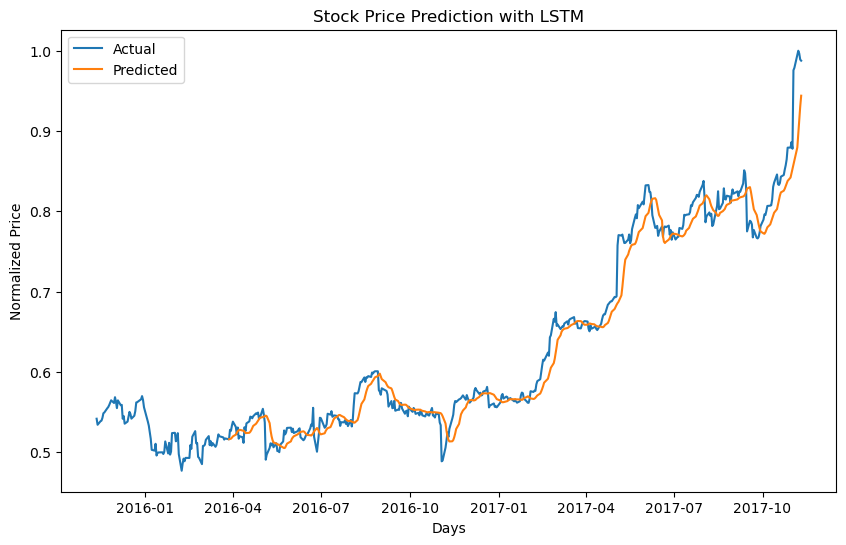

In [107]:
stocks = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NFLX', 'WMT', 'IBM', 'SNPS', 'ADBE', 'NVDA', 'CRM', 'AMD', 'INTC', 'ACN', 'ORCL', 'CSCO', 'ANSS']
window_size = 90
n_epochs = 100
learning_rate = 0.001
for stock in stocks:
    train_df, test_df = train_test_data[stock]
    build_train_eval_lstm(train_df, test_df, user_asset = 'stock', ticker = stock, forecast_range = 20, window_size = window_size, n_epochs = n_epochs, learning_rate = learning_rate, hidden_layer_size = 256)

Test Loss: 0.000341
MSE: 0.00034104997757822275
Accuracy: 0.9211195928753181
Precision: 0.9626865671641791
Recall: 0.9247311827956989
F1: 0.943327239488117


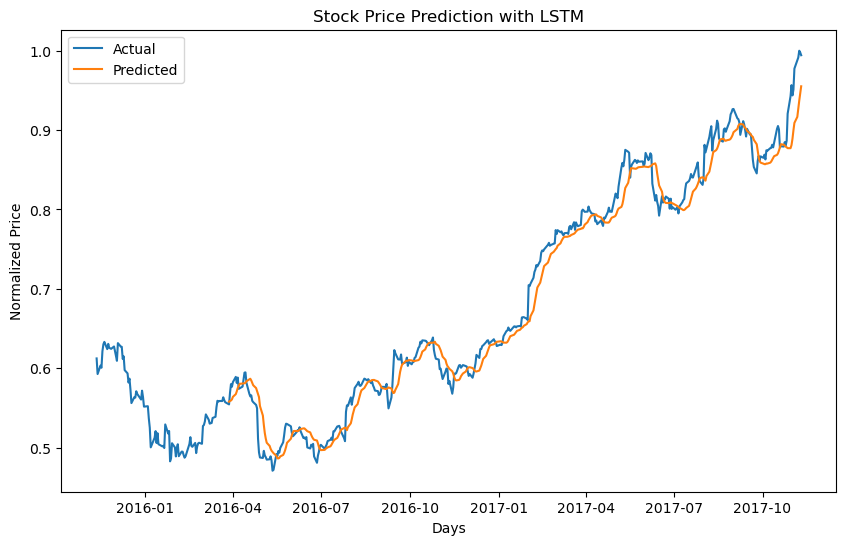

In [110]:
# try saved models
stock = 'AAPL'
windows_size = 90
train_df, test_df = train_test_data[stock]
model = load_model('stock', stock)
train_data, train_labels = generate_timeseries_windows(train_df.values, window_size, shift = 1)
test_data, test_labels = generate_timeseries_windows(test_df.values, window_size, shift = 1)
train_data = np.delete(train_data, [0], axis = 2)
test_data = np.delete(test_data, [0], axis = 2)
_, _, test_data_tensor, test_labels_tensor = convert_to_tensor(train_data, train_labels, test_data, test_labels)
output_single_stock = evaluate_model(model, test_data_tensor, test_labels_tensor)
mse = regression_metrics(test_labels_tensor, output_single_stock)
classification_metrics(test_labels_tensor, output_single_stock)
plot_predictions(test_df, output_single_stock)